# Testing Lily's wrapper

In [1]:
# import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

import sys
sys.path.append('..')
sys.path.append('../..')
from collections_env.gymcollectionsenv import CollectionsEnv 
from dcc import Parameters, AAV
from collections_env.discwrapper import DiscretizedObservationWrapper, DiscretizedActionWrapper
p = Parameters()    

aav= AAV(p)

from policies.qlearning import QlearningPolicy, TrainConfig
from policies.qlearningLily import QlearningPolicy as QlearningLil
from gym import spaces

n_actions = 3
MAX_ACTION = 1.0
env = CollectionsEnv()
env.action_space = spaces.Box(low=np.array([0]), high=np.array([MAX_ACTION]), dtype=np.float16)
denv = DiscretizedObservationWrapper(env, n_bins=[30, 10], log=False)
denva = DiscretizedActionWrapper(denv, n_bins=n_actions)
print(f'N states: {denva.observation_space.n}')

exact_v = -aav.u(env.lambda0, env.w0)


# obs_val_bins = [np.linspace(low_obs[0], high_obs[0], n_bins[0]),
#                             np.logspace(0, 20, base=(1-env.params.r_), num=n_bins[1]) * high_obs[1]]

[INFO] [2020-05-27 18:57:13,600] [AAV] - Instantiated @ AAV
N states: 300


In [2]:
denva.action_val_bins

[array([0. , 0.5, 1. ])]

In [3]:
bins = np.array([0., 1, 5])

denva = DiscretizedActionWrapper(denv, bins)

In [4]:
denva.action(2)

5.0

In [5]:
[a for a in denva.action_val_bins[0]]

[0.0, 1.0, 5.0]

Optimal greedy value

In [6]:
opt_greedy = np.max([-aav.u(env.lambda0 + a, env.w0) - a * denva.params.c for a in denva.action_val_bins[0]])
opt_greedy

70.77969768975915

In [7]:
[-aav.u(env.lambda0 + a, env.w0) - a * denva.params.c for a in denva.action_val_bins[0]]

[52.51486340170533, 70.77969768975915, 66.84271539430756]

In [11]:
-aav.u(env.lambda0 + 10, env.w0)

98.72335664168253

Non-optimal initialization

In [71]:
config1 = TrainConfig()
config1.n_episodes = 20000
config1.warmup_episodes = 10000
config1.epsilon = 1
config1.epsilon_final = 0.04
config1.alpha_decay = 0.9999
config1.alpha = 0.8

config2 = TrainConfig()
config2.n_episodes = 1000
config2.warmup_episodes = 1000
config2.epsilon = 0.0
config2.epsilon_final = 0.0
config2.alpha_decay = 0
config2.alpha = 0



# qln = QlearningPolicy(denv, denva, 'qlearn')
# qln.build(optimal=False)

# rewn = qln.train(config)
# plt.plot(rewn)
# plt.axhline(exact_v, linestyle='--', color='red')
# plt.xlabel('Episode')
# plt.ylabel('Avg reward per last 50 episodes')
# plt.show()



Optimal initialization

[INFO] [2020-05-22 13:55:52,980] [AAV] - Instantiated @ AAV


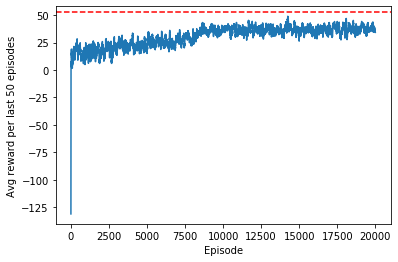

In [72]:
ql = QlearningPolicy(denv, denva, 'qlearn')
qlempty = QlearningPolicy(denv, denva, 'qlearn')
qlempty.build(optimal=True)
ql.build(optimal=False)
rew = ql.train(config1)
plt.plot(rew)
plt.axhline(exact_v, linestyle='--', color='red')
plt.xlabel('Episode')
plt.ylabel('Avg reward per last 50 episodes')
plt.show()




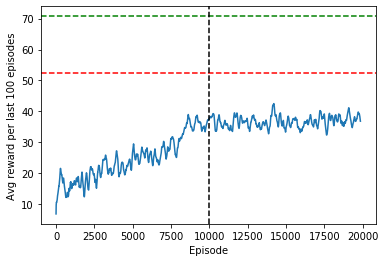

In [73]:
N = 150
plt.plot(np.convolve(rew, np.ones((N,))/N, mode='valid'))
plt.axhline(exact_v, linestyle='--', color='red')
plt.axhline(opt_greedy, linestyle='--', color='green')
plt.axvline(config1.warmup_episodes, linestyle='--', color='black')
plt.xlabel('Episode')
plt.ylabel('Avg reward per last 100 episodes')
plt.show()

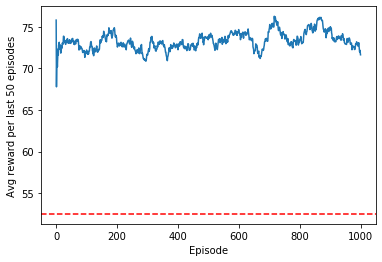

In [74]:
rewe = qlempty.train(config2)
plt.plot(rewe)
plt.axhline(exact_v, linestyle='--', color='red')
plt.xlabel('Episode')
plt.ylabel('Avg reward per last 50 episodes')
plt.show()



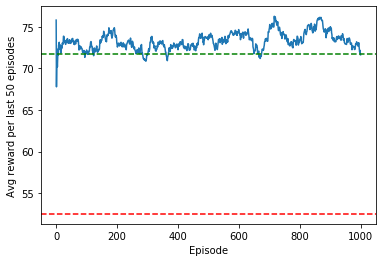

In [75]:
plt.plot(rewe)
plt.axhline(exact_v, linestyle='--', color='red')
plt.axhline(opt_greedy+1, linestyle='--', color='green')
plt.xlabel('Episode')
plt.ylabel('Avg reward per last 50 episodes')
plt.show()

In [76]:
import pandas as pd
import numpy
fivek = pd.read_csv("5Kruns.csv")
tenK = pd.read_csv("1Kruns.csv")

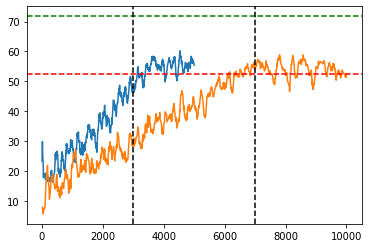

In [78]:
plt.plot(fivek['Step'], fivek['Value'])
plt.plot(tenK['Step'], tenK['Value'])
plt.axhline(exact_v, linestyle='--', color='red')
plt.axhline(opt_greedy+1, linestyle='--', color='green')
plt.axvline(3000, linestyle='--', color='black')
plt.axvline(7000, linestyle='--', color='black')

Transform state visits into a matrix

In [23]:
def plot_statespace(qlearning_instance):
    state_values = qlearning_instance.state_visits
    q_table = qlearning_instance.Q_table
    n_lambda = qlearning_instance.denv.obs_val_bins[0].shape[0]
    n_w = qlearning_instance.denv.obs_val_bins[1].shape[0]
    visit_map = np.zeros((n_lambda, n_w))
    actions_map = np.zeros((n_lambda, n_w))
    for i, line in enumerate(state_values):
        optimal_ac = np.argmax(line)
        x, y = denv._ind_to_cell(i)
        visit_map[x, y] = state_values[i]
        actions_map[x, y] = denva.action(np.argmax(q_table[i, :]))
    return visit_map, actions_map

In [24]:
qlempty.build(optimal=True)
heat_visits, heat_actions = plot_statespace(ql)
heat_visits_empty, heat_actions_empty = plot_statespace(qlempty)

[INFO] [2020-05-22 12:02:55,134] [AAV] - Instantiated @ AAV


In [25]:
truncated_heat_res = heat_visits[:, :9]

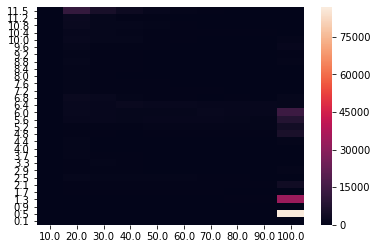

In [26]:
sns.heatmap(np.flip(heat_visits,0), yticklabels=np.flip(np.round(ql.denv.obs_val_bins[0],1)),  xticklabels=np.round(ql.denv.obs_val_bins[1],1))

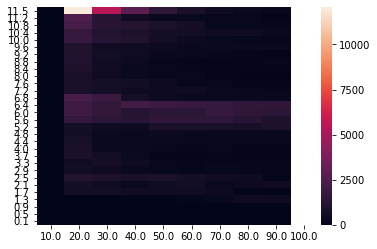

In [27]:
sns.heatmap(np.flip(truncated_heat_res,0), yticklabels=np.flip(np.round(ql.denv.obs_val_bins[0],1)),  xticklabels=np.round(ql.denv.obs_val_bins[1],1))

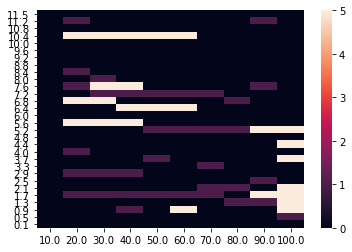

In [28]:
heat_actions_adjusted = heat_actions.copy()
heat_actions[heat_visits == 0] = 0.0
sns.heatmap(np.flip(heat_actions,0), yticklabels=np.flip(np.round(ql.denv.obs_val_bins[0],1)),  xticklabels=np.round(ql.denv.obs_val_bins[1],1))

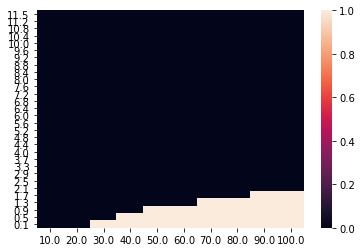

In [19]:

sns.heatmap(np.flip(heat_actions_empty,0), yticklabels=np.flip(np.round(ql.denv.obs_val_bins[0],1)),  xticklabels=np.round(ql.denv.obs_val_bins[1],1))

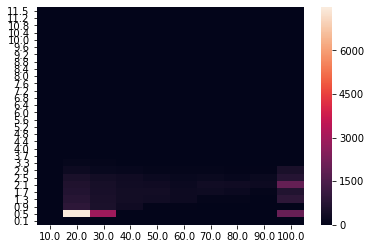

In [20]:
sns.heatmap(np.flip(heat_visits_empty,0), yticklabels=np.flip(np.round(ql.denv.obs_val_bins[0],1)),  xticklabels=np.round(ql.denv.obs_val_bins[1],1))

In [21]:
def plot_statespacepoints(qlearning_instance):
    state_values = qlearning_instance.state_visits
    q_table = qlearning_instance.Q_table
    n_lambda = qlearning_instance.denv.obs_val_bins[0].shape[0]
    n_w = qlearning_instance.denv.obs_val_bins[1].shape[0]
    visit_map = np.zeros((n_lambda, n_w))
    actions_map = np.zeros((n_lambda, n_w))
    xs = []
    ys = []
    ts = []
    ass = []
    for i, line in enumerate(state_values):
        optimal_ac = np.argmax(line)
        x, y = denv._ind_to_cell(i)
        xi, yi = denv._ind_to_cont(i)
        xs.append(xi)
        ys.append(yi)
        ts.append(state_values[i])
        ass.append(denva.action(np.argmax(q_table[i, :])))
    return np.array(xs), np.array(ys), np.array(ts), np.array(ass)

In [57]:
xs, ys, ts, ass = plot_statespacepoints(ql)

In [58]:
xs = xs[ts!=0]
ys = ys[ts!=0]
ass = ass[ts!=0]
ts = ts[ts!=0]

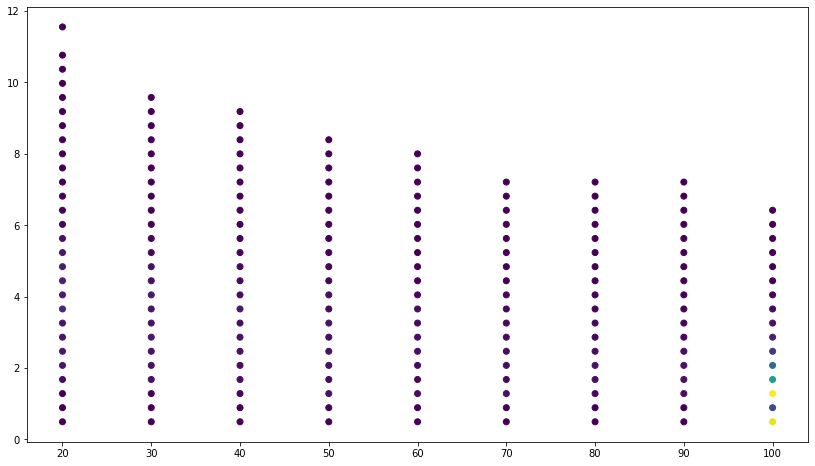

In [59]:
fig, ax = plt.subplots(figsize=(14,8))
ax.scatter(ys, xs, c=ts)

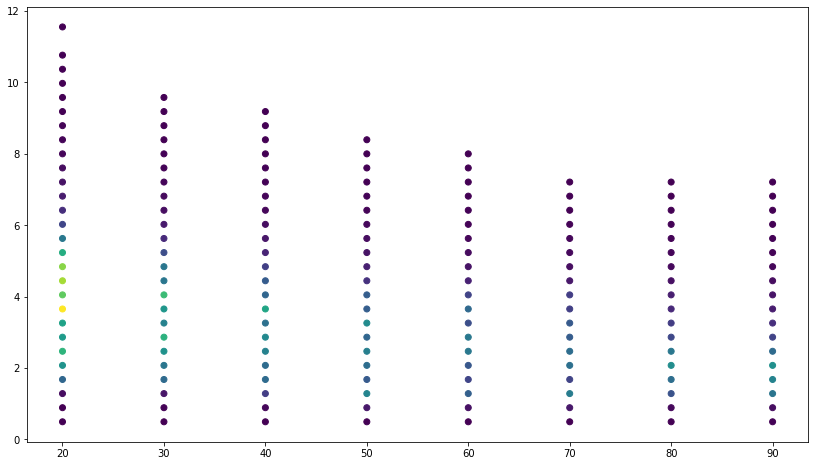

In [60]:
fig, ax = plt.subplots(figsize=(14,8))
ax.scatter(ys[ys!=100], xs[ys!=100], c=ts[ys!=100])

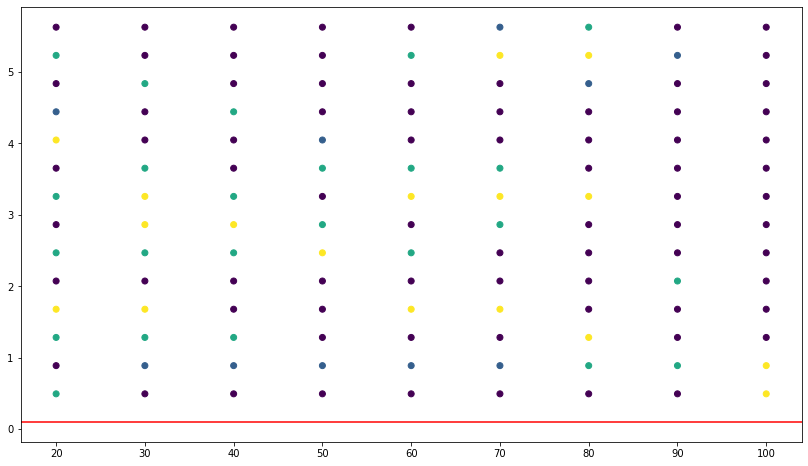

In [61]:
fig, ax = plt.subplots(figsize=(14,8))
ax.scatter(ys[xs<6], xs[xs<6], c=ass[xs<6])
ax.axhline(0.1, color='red')

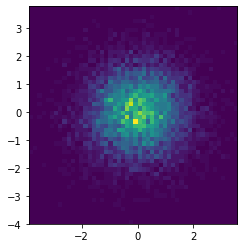

In [62]:
# Generate some test data
x = np.random.randn(8873)
y = np.random.randn(8873)

heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
ts, ys, xs = np.histogram2d(x, y, bins=50)
extent = [ys[0], ys[-1], xs[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

In [67]:
np.linalg.norm(ql.Q_table)

17571.801609230228

In [65]:
ql.Q_table

array([[0.00298912, 0.92756644, 0.91728788, 0.24038763],
       [0.80598851, 0.04880378, 0.69220769, 0.99055892],
       [0.27374133, 0.36773122, 0.97915059, 0.58848705],
       ...,
       [0.13296759, 0.72808127, 0.16870463, 0.19510559],
       [0.04591158, 0.36923987, 0.11174377, 0.61701907],
       [0.05295752, 0.23095615, 0.84312454, 0.39612836]])